In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#combining key csv files into one big dataframe and saving

import pandas as pd
import logging,time,os,math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.INFO, format = "%(asctime)s | %(levelname)s | %(message)s")
logger = logging.getLogger(__name__)

start_time = time.time()
racesdf = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/races.csv")

races_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/races.csv", sep = ",")
results_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/results.csv", sep = ",")
drivers_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/drivers.csv", sep = ",")
quali_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/qualifying.csv")
constructs_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/constructors.csv", sep = ",")
constructs_results_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/constructor_results.csv", sep = ",")
circuits_df = pd.read_csv(r"/content/drive/MyDrive/f1_pred/train_dataset/circuits.csv", sep = ",")

#combine into one df
df = races_df.merge(results_df, on="raceId")
df = df.merge(quali_df, on = ['raceId', 'driverId'])

# Ensure 'driverName' exists by combining 'forename' and 'surname' if necessary
if 'driverName' not in drivers_df.columns:
	drivers_df['driverName'] = drivers_df['forename'] + ' ' + drivers_df['surname']
df = df.merge(drivers_df[['driverId', 'driverName']], on = 'driverId')

#df= df.merge(constructs_results_df[['constructorResultsId']], on='constructorId')
df= df.merge(constructs_df[['constructorId', 'constructorRef']], left_on='constructorId_y', right_on='constructorId')

df = df.merge(circuits_df[['circuitId', 'circuitRef']], left_on='circuitId', right_on='circuitId')


columns_to_drop = [
    'constructorId_x',
    'constructorId_y',
    'number_x', 'number_y',
    'position_x', 'position_y',
    'time_x', 'time_y', 'circuitId_x',
    'url', 'positionText'
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns = columns_to_drop)

#truncate and remove earlier seasons
df = df[df['year'] >=2021]

print(df.columns)

df.to_parquet('/content/drive/MyDrive/f1_pred/train_dataset/complete_dataset.parquet')

#print(df[['positionOrder']])




Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'fp1_date',
       'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'resultId',
       'driverId', 'grid', 'positionOrder', 'points', 'laps', 'milliseconds',
       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'qualifyId', 'q1', 'q2', 'q3', 'driverName', 'constructorId',
       'constructorRef', 'circuitRef'],
      dtype='object')


In [3]:
def convert_to_seconds(t):
  # Check if the input is a string or a number before processing
  if not isinstance(t, (str, int, float)):
      return None # Return None for non-string/non-numeric types

  if pd.isna(t) or str(t).strip() == '\\N' or str(t).strip() == '': # Check for pandas NaN, '\\N', or empty string
    return None
  t_str = str(t).strip() # Convert to string and remove leading/trailing whitespace
  if ':' in t_str:
    # Split by the last colon to handle potential hours or other multiple colons
    parts = t_str.rsplit(':', 1)
    if len(parts) == 2:
        m, s = parts
        # Check if the first part (minutes or hours) also contains a colon
        if ':' in m:
            h, m = m.split(':', 1)
            try:
                return int(h) * 3600 + int(m) * 60 + float(s)
            except ValueError:
                return None
        else:
            try:
                return int(m) * 60 + float(s)
            except ValueError:
                return None
    else:
        # Handle cases where there's no colon but it's not a valid float
        try:
            return float(t_str)
        except ValueError:
            return None
  else:
    # Attempt conversion and handle potential errors for other non-standard strings
    try:
      return float(t_str)
    except ValueError:
      return None

def common_feature_eng(train_set):
  #Just a few simple features to start off with!

  for col in ['q1', 'q2', 'q3', 'fastestLapTime']:
      if col in train_set.columns: # Check if column exists before applying
           train_set[col + '_sec'] = train_set[col].apply(convert_to_seconds)

  #sort by date
  train_set = train_set.sort_values(['driverId', 'date'])

  #feature eng #1: Qualifying position
  for col in ['q1', 'q2', 'q3']:
      if col + '_sec' in train_set.columns:
           train_set[col + '_rank'] = train_set.groupby('raceId')[col + '_sec'].rank(ascending=True, method='min')

  # Sort by driver and date for rolling features
  train_set = train_set.sort_values(['driverId', 'date'])

  #Use only past race info for features
  train_set.loc[:, "positionOrder_shifted"] = train_set.groupby('driverId')['positionOrder'].shift(1)
  train_set.loc[:, "grid_shifted"] = train_set.groupby("driverId")["grid"].shift(1)

  #Feature eng #2: Driver recent form: average over last 3 races
  train_set.loc[:,"driver_recent_form"] = train_set.groupby('driverId')['positionOrder_shifted'].transform(lambda x: x.shift(1).rolling(window = 3, min_periods = 1).mean())

  #Feature eng #3: Constructor historical win rate (2020-2024)
  train_set['is_win'] = (train_set['positionOrder'] == 1).astype(int)
  train_set['is_win'] = train_set.groupby(['constructorId'])['is_win'].shift(1)

  train_set.loc[:, "rolling_constructor_wins"] = train_set.groupby(['constructorId'])['is_win'].transform(lambda x: x.shift(1).rolling(window = 5, min_periods = 1).sum())
  train_set.loc[:, "constructor_races"] = train_set.groupby(['constructorId'])['raceId'].transform(lambda x: x.shift(1).rolling(window = 5, min_periods = 1).count())
  train_set.loc[:, "Constructor_win_rate"] = (train_set['rolling_constructor_wins']/ train_set['constructor_races'].replace(0, np.nan))

   # Fill NaN values that might arise from the rolling operations
  train_set['driver_recent_form'] = train_set['driver_recent_form'].fillna(train_set['positionOrder'].mean())
  train_set['Constructor_win_rate'] = train_set['Constructor_win_rate'].fillna(0)



  return train_set

def podium_feature(train_set):

  train_set = train_set.copy()

  #Lets sort first:
  train_set = train_set.sort_values(['driverId', 'date'])

  #First specific feature eng for MOE #1:
  #feature eng: recent podium streak
  train_set['podium_experience'] = train_set.groupby('driverId')['positionOrder'].transform(lambda x: (x.shift(1) <= 3).expanding().mean())

  train_set['podium_recent_count'] = train_set.groupby('driverId')['positionOrder'].transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(lambda s: (s <= 3).sum(), raw=True))
  train_set['team_recent_wins'] = train_set.groupby('constructorId')['positionOrder'].transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(lambda s: (s == 1).sum(), raw=True))


  return train_set[['podium_experience', 'podium_recent_count', 'team_recent_wins']] #Return only new feature


def midfield_feature(train_set):

  train_set = train_set.copy()

  # Ensure proper sorting
  train_set = train_set.sort_values(['driverId', 'date'])

  #second specific feature eng for MOE #2:
  train_set['points_consistency'] = train_set.groupby('driverId')['positionOrder'].transform(lambda x: x.shift(1).rolling(5,min_periods = 1).std() / x.shift(1).mean() + 1e-6)
  train_set.loc[:, "grid_shifted"] = train_set.groupby("driverId")["grid"].shift(1)
  train_set['avg_grid_recent'] = train_set.groupby('driverId')['grid'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean()) #This feature boosts the results quite a bit nice!!


  return train_set[['points_consistency', 'avg_grid_recent']]

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import numpy as np

def preprocess(df, encoder = None):

  #deal with the dates
  df = df.copy()

  # Replace '\\N' with NaN before any conversions
  #df = df.replace('\\N', np.nan)

  # Convert known time columns to seconds
  time_cols = ['q1', 'q2', 'q3', 'fastestLapTime', 'fp1_time', 'fp2_time', 'fp3_time', 'quali_time', 'sprint_time', 'time']
  for col in time_cols:
      if col in df.columns:
          df[col + '_sec'] = df[col].apply(convert_to_seconds)
          df = df.drop(columns=[col])


  date_cols = ['fp1_date', 'fp2_date', 'fp3_date', 'quali_date', 'sprint_date', 'date']
  for col in date_cols:
      # Use errors='coerce' to turn invalid date formats into NaT (Not a Time)
      df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')

      # Extract date features, handling potential NaT values
      df[col + '_year'] = df[col].dt.year
      df[col + '_month'] = df[col].dt.month
      df[col + '_day'] = df[col].dt.day
      # Drop the original date column after extracting features
      df = df.drop(columns=[col])

  #Now for categorical cols that need to be encoded
  categorical_cols = ['name', 'driverName', 'constructorRef', 'circuitRef']

  if encoder is None: #so we only fit during training
    #Now encode them
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    df_encoded = encoder.fit_transform(df[categorical_cols])

  else:
    df_encoded = encoder.transform(df[categorical_cols])


  df_encoded_feature = pd.DataFrame(df_encoded, columns = encoder.get_feature_names_out(categorical_cols), index=df.index)

  #Now combine and drop old columns
  df_updated = pd.concat([df, df_encoded_feature], axis= 1)
  df_updated = df_updated.drop(columns = categorical_cols)

  # Convert any remaining object columns to numeric, coercing errors
  for col in df_updated.select_dtypes(include=['object']).columns:
      df_updated[col] = pd.to_numeric(df_updated[col], errors='coerce')


  return df_updated,encoder

In [32]:
#Model #1: Rankings of podium (top 3) spots
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, roc_auc_score, recall_score, ndcg_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier, LGBMRanker, early_stopping
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
import shap

def model1_binary(x_train, x_val, y_train, y_val, train_groups, val_groups):

  lgb = LGBMRanker(
      objective= 'lambdarank',
      metric = 'ndcg',
      n_estimators= 100,
      learning_rate=0.1,
      importance_type = 'gain',
      num_leaves= 35,
      random_state=42,
      eval_at = [1, 2, 3] # Specify eval_at in the constructor
  )



  lgb.fit(x_train, y_train, group=train_groups, eval_set=[(x_val, y_val)],  eval_group=[val_groups],
        callbacks=[early_stopping(stopping_rounds = 10, verbose = True)])


  explainer = shap.Explainer(lgb.predict, x_train)
  shape_values = explainer(x_val)
  shap.summary_plot(shape_values, x_val, max_display = 13)
  shap.plots.bar(shape_values, max_display=10)


  y_pred = lgb.predict(x_val)
  print(" ##### LIGHTGBM FOR MODEL#1 PODIUM ###### ")
  print(f" MSE: {mean_squared_error(y_val, y_pred)}")
  #print(f" NDCG@3 {ndcg_score([y_val], [y_pred], k=3)}")

  return lgb

In [6]:
#Model #2: Rankings of positions 4-10 (middle)

from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, roc_auc_score, recall_score, mean_squared_error, ndcg_score
import shap
from sklearn.model_selection import RandomizedSearchCV
import lightgbm
from lightgbm import LGBMClassifier, LGBMRanker, early_stopping
from lightgbm.callback import early_stopping
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import warnings


warnings.filterwarnings("ignore", category=UserWarning)


def model2_middle(x_train, x_val, y_train, y_val, train_groups, val_groups):


  lgb = LGBMRanker(
      objective= 'lambdarank',
      metric = 'ndcg',
      n_estimators= 100,
      learning_rate=0.1,
      importance_type = 'gain',
      random_state=42,
      eval_at = [10]
  )



  lgb.fit(x_train, y_train, group=train_groups, eval_set=[(x_val, y_val)],  eval_group=[val_groups],
        callbacks=[early_stopping(stopping_rounds = 10, verbose = True)])

  #explainer = shap.Explainer(lgb.predict, x_train)
  #shape_values = explainer(x_val)
  #shap.summary_plot(shape_values, x_val, max_display = 25)

  y_pred = lgb.predict(x_val)
  print(" ##### LIGHTGBM FOR MODEL2 MIDDLE ###### ")
  print(f" MSE: {mean_squared_error(y_val, y_pred)}")


  return lgb

In [7]:
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd

def evaluate_ranked_predictions(preds_df, true_df, k=10, verbose=False):
    """
    Evaluates ranking predictions using NDCG@k and Top-K Hit Accuracy.

    Parameters:
    - preds_df: DataFrame with columns ['raceId', 'driverId', 'score'] (or any rankable column)
    - true_df: DataFrame with columns ['raceId', 'driverId', 'positionOrder']
    - k: top-k cutoff
    - verbose: if True, print sample debug info

    Returns:
    - ndcg_avg: average NDCG@k over all races
    - hit_acc: Top-k hit accuracy across all races
    """

    # Rename score column to standardized for merging
    preds = preds_df.rename(columns={'score': 'pred_score'})

    # Merge ground truth
    merged = preds.merge(true_df[['raceId', 'driverId', 'positionOrder']], on=['raceId', 'driverId'], how='left')
    merged['positionOrder'] = pd.to_numeric(merged['positionOrder'], errors='coerce')
    merged = merged.dropna(subset=['positionOrder'])
    merged['positionOrder'] = merged['positionOrder'].astype(int)

    # Assign relevance (e.g., 10 for 1st, 9 for 2nd, etc.)
    merged['relevance'] = (k + 1 - merged['positionOrder']).clip(lower=0)

    ndcg_scores = []
    hits = 0
    total_races = 0

    for race_id, group in merged.groupby("raceId"):
        group = group.sort_values("pred_score", ascending=False).head(k)
        true_relevance = group['relevance'].values
        pred_scores = group['pred_score'].values

        if len(true_relevance) < k:
            continue

        ndcg = ndcg_score([true_relevance], [pred_scores], k=k)
        ndcg_scores.append(ndcg)

        # Check if at least one correct driver was in top-k
        top_k_pred_ids = group['driverId'].tolist()
        true_top_k_ids = true_df[(true_df['raceId'] == race_id) & (true_df['positionOrder'] <= k)]['driverId'].tolist()

        if len(set(top_k_pred_ids) & set(true_top_k_ids)) > 0:
            hits += 1

        total_races += 1

        if verbose:
            print(f"\n--- Race {race_id} ---")
            print("Top-K Predictions:", top_k_pred_ids)
            print("True Top-K:", true_top_k_ids)
            print(f"NDCG@{k}: {ndcg:.4f}")

    ndcg_avg = np.mean(ndcg_scores) if ndcg_scores else 0.0
    hit_acc = hits / total_races if total_races > 0 else 0.0

    return ndcg_avg, hit_acc


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def predict_and_plot_spa_grand_prix(test_set, x_test_raw, x_test_processed, x_test_processed2, model1, model2):
    # Define drivers NOT in 2025 season (to exclude)
    excluded_drivers_2025 = [
        822,  # Valtteri Bottas - moved to Audi (2026)
        825,  # Kevin Magnussen - no F1 seat
        817   # Daniel Ricciardo - retired
    ]

    # 1. Filter Spa 2025
    spa_test = test_set[test_set['circuitRef'] == 'spa'].copy()
    if spa_test.empty:
        print("❗ No Spa 2025 data found in test_set.")
        return

    race_id = spa_test['raceId'].iloc[0]

    # 2. Model 1 predictions (top 3) - YOUR ORIGINAL LOGIC
    spa_preds_m1 = spa_test[['raceId', 'driverId']].copy()
    spa_preds_m1['score'] = model1.predict(x_test_processed[x_test_raw['circuitRef'] == 'spa'])
    spa_preds_m1['rank'] = spa_preds_m1.groupby('raceId')['score'].rank(ascending=False, method='first')

    # 3. Model 2 predictions (4-10) - YOUR ORIGINAL LOGIC
    spa_preds_m2 = spa_test[['raceId', 'driverId']].copy()
    spa_preds_m2['score'] = model2.predict(x_test_processed2[x_test_raw['circuitRef'] == 'spa'])
    spa_preds_m2['rank'] = spa_preds_m2.groupby('raceId')['score'].rank(ascending=False, method='first') + 3  # offset

    # 4. Select top 3 and P4–P10 - FIXED to prevent duplicates
    top3 = spa_preds_m1[spa_preds_m1['rank'] <= 3]

    # Remove drivers already in top3 from model2 predictions
    remaining_drivers = spa_preds_m2[~spa_preds_m2['driverId'].isin(top3['driverId'])]

    # Take next 7 best drivers (positions 4-10)
    p4_p10 = remaining_drivers[remaining_drivers['rank'] <= 10]

    final_pred = pd.concat([top3, p4_p10])
    final_pred = final_pred.sort_values('rank')
    final_pred['driverName'] = final_pred['driverId'].map(dict(zip(spa_test['driverId'], spa_test['driverName'])))

    # 5. *** ONLY NEW PART *** - Filter out non-2025 drivers and re-rank
    final_pred_filtered = final_pred[~final_pred['driverId'].isin(excluded_drivers_2025)].copy()
    final_pred_filtered['rank'] = range(1, len(final_pred_filtered) + 1)  # Re-rank 1,2,3,4...

    print(f"📊 Removed {len(final_pred) - len(final_pred_filtered)} non-2025 drivers")
    print("\n🏁 Spa 2025 Final Prediction (2025 Drivers Only):")
    print(final_pred_filtered[['rank', 'driverName', 'driverId']])

    # 6. Podium-style plot - YOUR ORIGINAL PLOT
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    palette = []
    for r in final_pred_filtered['rank']:
        if r == 1:
            palette.append("#FFD700")  # gold
        elif r == 2:
            palette.append("#C0C0C0")  # silver
        elif r == 3:
            palette.append("#CD7F32")  # bronze
        else:
            palette.append("#4682B4")  # steel blue

    sns.barplot(
        x='driverName',
        y='score',
        data=final_pred_filtered,
        palette=palette
    )

    plt.title("🏎️ Spa Grand Prix 2025 - Top 10 Driver Predictions", fontsize=14)
    plt.ylabel("Prediction Score")
    plt.xlabel("Driver")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return final_pred_filtered

# Alternative simple approach for existing results:
def filter_existing_predictions(final_pred):
    """Simple filter for already-generated predictions"""
    excluded_drivers_2025 = [822, 825, 817]  # Bottas, Magnussen, Ricciardo

    filtered = final_pred[~final_pred['driverId'].isin(excluded_drivers_2025)].copy()
    filtered['rank'] = range(1, len(filtered) + 1)  # Re-rank

    return filtered

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 54
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/tmp/ipython-input-32-1372059378.py:36: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shape_values, x_val, max_display = 13)


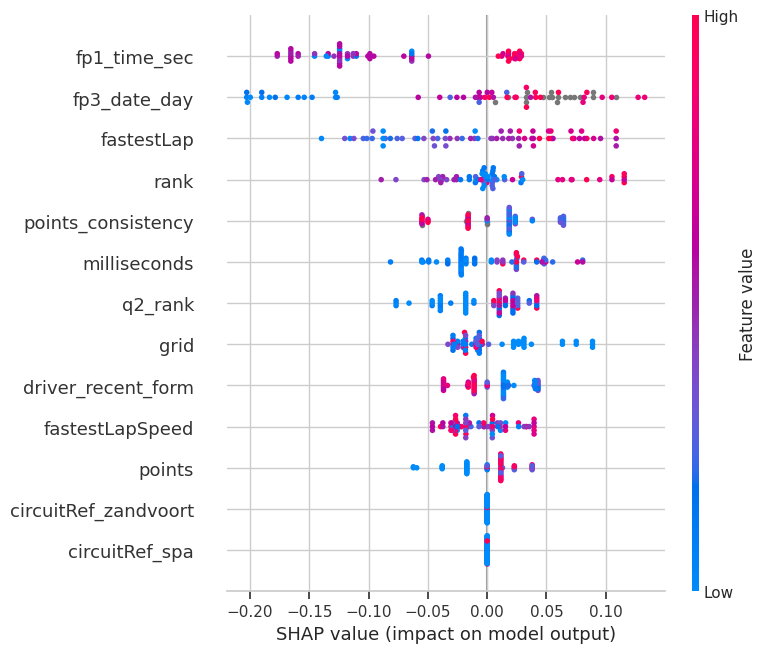

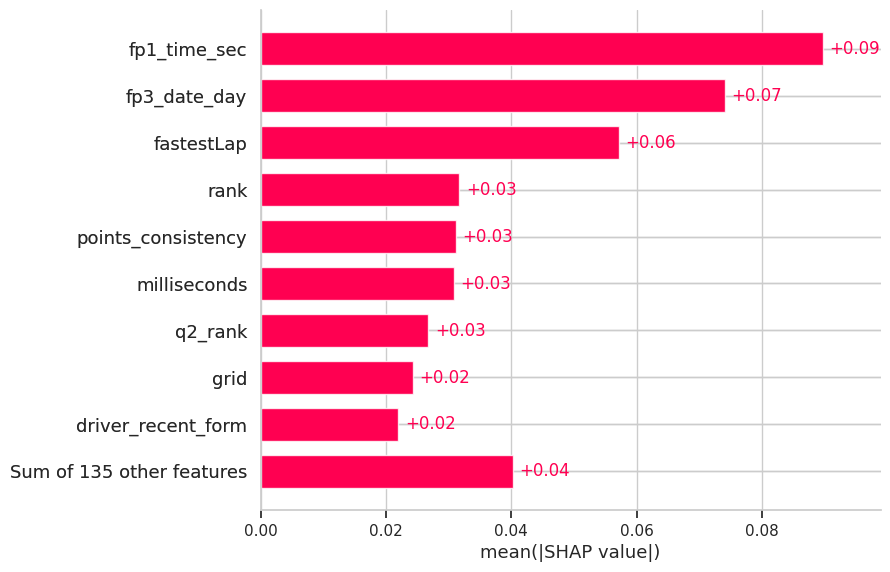

 ##### LIGHTGBM FOR MODEL#1 PODIUM ###### 
 MSE: 4.985575672523484
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 308, number of used features: 61
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/tmp/ipython-input-8-2389256117.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


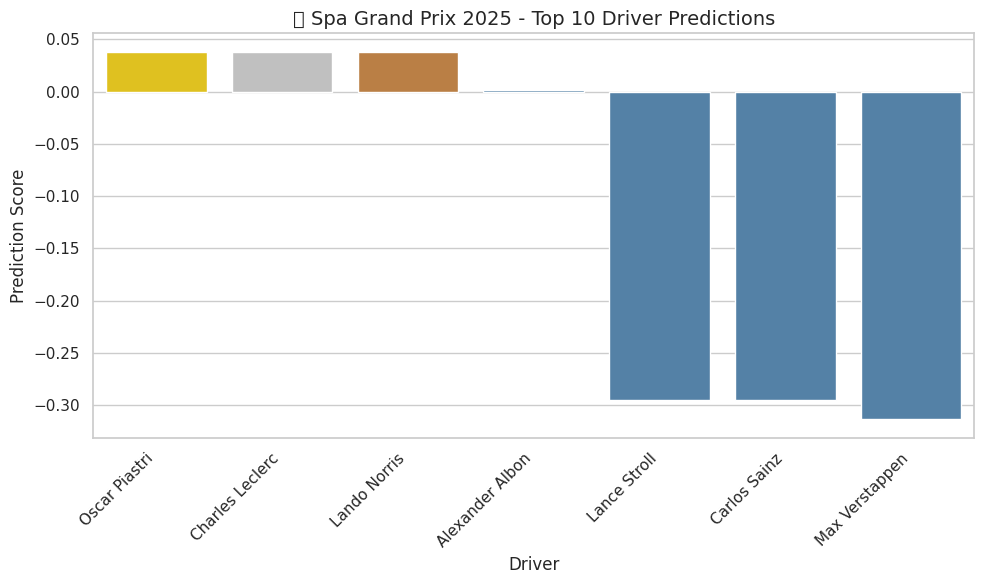

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

def main():
  #main method to run everything!
  df.to_parquet('/content/drive/MyDrive/f1_pred/train_dataset/complete_dataset.parquet')

  #split into train/test: using a nested time based approach
  train_val_set = df[df['year'].between (2021, 2023)]  # 2021-2023
  test_set = df[df['year'] == 2024].copy() # 2024 to evaluate on!

  #temp split for hp tuning
  train = train_val_set[train_val_set['year'] < 2023].copy()
  val = train_val_set[train_val_set['year'] == 2023] .copy()

  #print("Train set shape:", train.shape)
  #print("Validation set shape:", val.shape)
  #print("Test set shape:", test_set.shape)

  #
  x_train_raw = train.copy()
  x_val_copy_raw = val.copy()
  x_test_raw = test_set.copy()

  #feature eng
  x_train_common_featured = common_feature_eng(x_train_raw)
  x_val_common_featured = common_feature_eng(x_val_copy_raw)
  x_test_common_featured = common_feature_eng(x_test_raw)

  x_train_podium_featured = podium_feature(x_train_raw)
  x_val_podium_featured = podium_feature(x_val_copy_raw)
  x_test_podium_featured = podium_feature(x_test_raw)

  x_train_midfield_featured = midfield_feature(x_train_raw)
  x_val_midfield_featured = midfield_feature(x_val_copy_raw)
  x_test_midfield_featured = midfield_feature(x_test_raw)

  #Features for model1 combined
  x_train_featured = pd.concat([x_train_common_featured, x_train_podium_featured, x_train_midfield_featured], axis=1)
  x_val_featured = pd.concat([x_val_common_featured, x_val_podium_featured, x_val_midfield_featured], axis=1)
  x_test_featured = pd.concat([x_test_common_featured, x_test_podium_featured, x_test_midfield_featured], axis=1)

  #Features for model2, selective combination
  x_train_featured2 = pd.concat([x_train_common_featured, x_train_midfield_featured], axis=1)
  x_val_featured2 = pd.concat([x_val_common_featured ,x_val_midfield_featured], axis=1)
  x_test_featured2 = pd.concat([x_test_common_featured, x_test_midfield_featured], axis=1)

  #Remove columns that contain the answers after feature eng
  exclude_cols = ['positionOrder', 'resultId', 'raceId', 'is_win', 'circuitRef_zandvoort', 'circuitRef_monza', 'circuitRef_miami', 'q2_sec'

      'circuitRef_spa',
      'circuitRef_yas_marina',
      'circuitRef_villeneuve',
      'circuitRef_suzuka',
      'circuitRef_losail',
      'circuitRef_marina_bay',
      'circuitRef_monaco',
      'circuitRef_monza',
      'circuitRef_portimao',
      'circuitRef_red_bull_ring',
      'circuitRef_ricard',
      'circuitRef_rodriguez']

  exclude_cols_model2 = [
    'positionOrder', 'resultId', 'raceId', 'is_win',
    'podium_experience', 'constructorId', 'circuitId',
    'driverId', 'qualifyId', 'milliseconds'
  ]
  feature_cols_model1 = [col for col in x_train_featured.columns if col not in exclude_cols]
  feature_cols_model2 = [col for col in x_train_featured2.columns if col not in exclude_cols_model2]

  x_train = x_train_featured[feature_cols_model1]
  x_val = x_val_featured[feature_cols_model1]
  x_test = x_test_featured[feature_cols_model1]

  x_train2 = x_train_featured2[feature_cols_model2]
  x_val2 = x_val_featured2[feature_cols_model2]
  x_test2 = x_test_featured2[feature_cols_model2]

  #Model 1 now preprocess:
  x_train_processed, fitted_encoder = preprocess(x_train, encoder = None)

  x_val_processed, _ = preprocess(x_val, encoder = fitted_encoder)
  x_test_processed, _ = preprocess(x_test, encoder = fitted_encoder)

  #Model2 now preprocess:
  x_train_processed2, fitted_encoder2 = preprocess(x_train2, encoder = None)

  x_val_processed2, _ = preprocess(x_val2, encoder = fitted_encoder2)
  x_test_processed2, _ = preprocess(x_test2, encoder = fitted_encoder2)


  #Model #1: LightGBM ranker of podium
  podium_mask_train = (train['positionOrder'] <=3)
  x_train_processed1 = x_train_processed[podium_mask_train]
  y_train_model1 = train.loc[podium_mask_train, 'positionOrder']

  podium_mask_val = (val['positionOrder'] <=3)
  x_val_processed1 = x_val_processed[podium_mask_val]
  y_val_model1 = val.loc[podium_mask_val, "positionOrder"]

  # Define groups for LGBMRanker based on 'raceId'
  train_groups1 = train.loc[podium_mask_train].groupby('raceId').size().values
  val_groups1 = val.loc[podium_mask_val].groupby('raceId').size().values

  #Train the first model
  moe_model1 = model1_binary(x_train_processed1, x_val_processed1, y_train_model1, y_val_model1, train_groups1, val_groups1)

  #Model 2: LightGBM ranker
  #only for positions 4 to 10
  midfield_mask_train = (train['positionOrder'] >=4) & (train['positionOrder'] <=10)
  x_train_processed2 = x_train_processed2.loc[midfield_mask_train]
  y_train_model2 = train.loc[midfield_mask_train, 'positionOrder'].astype(int)

  midfield_mask_val = (val['positionOrder'] >=4) & (val['positionOrder']<=10)
  x_val_processed2 = x_val_processed2.loc[midfield_mask_val]
  y_val_model2 = val.loc[midfield_mask_val, 'positionOrder'].astype(int)

  # Define groups for LGBMRanker based on 'raceId'
  train_groups2 = train.loc[midfield_mask_train].groupby('raceId').size().values
  val_groups2 = val.loc[midfield_mask_val].groupby('raceId').size().values

  #Train the second model
  moe_model2 = model2_middle(x_train_processed2, x_val_processed2, y_train_model2, y_val_model2, train_groups2, val_groups2)

  #Now evaluate the models seperatly!
  mode1_preds = test_set[['raceId', 'driverId']].copy()
  mode1_preds['score'] = moe_model1.predict(x_test_processed)

  ndcg3,hit3 = evaluate_ranked_predictions(mode1_preds, test_set, k = 3)
  print(f" 🎯 Model 1 - NDCG@3: {ndcg3:.4f}, Hit@3: {hit3:.4f}")

  model2_preds = test_set[['raceId', 'driverId']].copy()
  model2_preds['score'] = moe_model2.predict(x_test_processed2)

  midfield_truth = test_set[test_set['positionOrder'].between(4,10)]

  ndcg7,hit7 = evaluate_ranked_predictions(model2_preds, midfield_truth, k = 7)
  print(f" 🎯 Model 2 - NDCG@7: {ndcg7:.4f}, Hit@7: {hit7:.4f}")

  #predict and plot!
  predict_and_plot_spa_grand_prix(test_set,
                                  x_test_raw,
                                  x_test_processed,
                                  x_test_processed2,
                                  moe_model1,
                                  moe_model2)


if __name__ == '__main__':
  main()